# Load functions

In [1]:

import pandas as pd
import numpy as np
import json
import time
from datasets import Dataset
from datasets import DatasetDict
from datasets import load_from_disk
import pickle

import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import PreTrainedTokenizerFast
from sklearn.model_selection import train_test_split


import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

In [2]:
from ast import literal_eval
def string_to_python(s):
    try:
        return literal_eval(s)
    except ValueError:
        return None

In [4]:
# Function to extract non-empty IDs
def extract_ids(author_list):
    return [author['id'] for author in author_list if author['id']]

In [3]:
def eda(pdf, list_col):
    import matplotlib.pyplot as plt
    for c in list_col:
        pdf[c].plot.hist(bins =120, alpha = 0.5)
        plt.title(f"Distribution of {c}")
        plt.show()
        plt.clf()

# Prepare data for modelling

## Read in expertise

In [2]:
num_sublists = 50
gpt_model = "gpt-4o"
list_of_res = []

for sublist_number in range(num_sublists):
    loaded_results = []
    with open(f"data/label/results_{sublist_number}_{gpt_model}.json", 'r') as f:
        for line in f:
            try:
                result = json.loads(line)
                loaded_results.append(result)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
            
    list_of_res.append(loaded_results)
print(len(list_of_res))

50


In [3]:
list_expertise_topic = []
for l in list_of_res:
    list_expertise_topic += l
print(len(list_expertise_topic))

64064


In [4]:
list_expertise_topic[0]

{'id': '53e9a0edb7602d97029d45c4',
 'expertise': ['Mathematics',
  'Discrete Mathematics',
  'Graph Theory',
  'Combinatorics',
  'Algorithm Design',
  'Complexity Theory',
  'Approximation Algorithms',
  'Hardness of Approximation',
  'Multicommodity Flow Problems',
  'Edge-Disjoint Paths Problems'],
 'topic': ['Mathematics',
  'Discrete Mathematics',
  'Graph Theory',
  'Combinatorics',
  'Algorithmic Complexity',
  'Approximation Algorithms',
  'Hardness of Approximation',
  'Multicommodity Flow',
  'Edge-Disjoint Paths',
  'Node-Disjoint Paths']}

In [5]:
df_expertise = pd.DataFrame(list_expertise_topic, columns=['id', 'expertise', "topic"])[["id", "expertise"]]
print(df_expertise.shape)
display(df_expertise.head())

(64064, 2)


,id,expertise
0,53e9a0edb7602d97029d45c4,"[Mathematics, Discrete Mathematics, Graph Theo..."
1,53e9b5cfb7602d970411c8a3,"[Machine Learning, Data Science, Statistical A..."
2,599c7ef9601a182cd28ddd55,"[Mathematical optimization, Linear programming..."
3,5cfa5b985ced2477cb3c5177,"[Computer Science, Data Science, Data Engineer..."
4,57d06412ac4436735429bbfe,"[Computer Science, Data Mining, Cloud Computin..."


## Read in paper

In [6]:
paper = pd.read_csv("./output/paper.csv"
                    , dtype = {"id": "string"
                                , "year": int
                                , "lang": "string" 
                                , "title": "string"
                                , "abstract" : "string"
                                , "keywords" : "string"
                                , "abstract_length": int
                                , "list_of_venue": object
                                , "list_of_field_of_study": object})
print(paper.shape)
print(paper.columns)
display(paper.head())

(3216456, 9)
Index(['id', 'year', 'lang', 'title', 'abstract', 'keywords',
       'abstract_length', 'list_of_venue', 'list_of_field_of_study'],
      dtype='object')


,id,year,lang,title,abstract,keywords,abstract_length,list_of_venue,list_of_field_of_study
0,53e99785b7602d9701f43f95,2004,en,Bookshelf,Reviewed: Succeeding with Open Source Quality ...,"['415', '460', ' P.K.', ' Volume 4: Anticipati...",152,"['Software, IEEE']",NaN
1,53e9978ab7602d9701f4a038,2002,en,Neurointerfaces,A neurointerface is a nonlinear filtering syst...,"['Humans', 'Automatic control', 'Nonlinear equ...",835,['Neurointerfaces'],NaN
2,53e9978ab7602d9701f4bc56,2007,en,Lisp,This report covers the activities of the 3rd E...,"['Nick Levine', 'relevant organisational aspec...",335,['European Conference on Object-Oriented Progr...,NaN
3,53e9978db7602d9701f50771,2016,en,interactions,"Given a C ∗ -algebra B , a closed * -subalgebr...","['transfer operator', 'generalized corresponde...",1123,['interactions'],NaN
4,53e99792b7602d9701f547ef,2007,en,Synergetics,"Synergetics, a rather new interdisciplinary fi...","['General Principle', ' Functional Structure',...",632,['Physica B+C'],NaN


In [7]:
display(paper.head())

,id,year,lang,title,abstract,keywords,abstract_length,list_of_venue,list_of_field_of_study
0,53e99785b7602d9701f43f95,2004,en,Bookshelf,Reviewed: Succeeding with Open Source Quality ...,"['415', '460', ' P.K.', ' Volume 4: Anticipati...",152,"['Software, IEEE']",NaN
1,53e9978ab7602d9701f4a038,2002,en,Neurointerfaces,A neurointerface is a nonlinear filtering syst...,"['Humans', 'Automatic control', 'Nonlinear equ...",835,['Neurointerfaces'],NaN
2,53e9978ab7602d9701f4bc56,2007,en,Lisp,This report covers the activities of the 3rd E...,"['Nick Levine', 'relevant organisational aspec...",335,['European Conference on Object-Oriented Progr...,NaN
3,53e9978db7602d9701f50771,2016,en,interactions,"Given a C ∗ -algebra B , a closed * -subalgebr...","['transfer operator', 'generalized corresponde...",1123,['interactions'],NaN
4,53e99792b7602d9701f547ef,2007,en,Synergetics,"Synergetics, a rather new interdisciplinary fi...","['General Principle', ' Functional Structure',...",632,['Physica B+C'],NaN


In [8]:
paper = paper[["id"#, "year"
               , "abstract"]]
display(paper.head())

,id,abstract
0,53e99785b7602d9701f43f95,Reviewed: Succeeding with Open Source Quality ...
1,53e9978ab7602d9701f4a038,A neurointerface is a nonlinear filtering syst...
2,53e9978ab7602d9701f4bc56,This report covers the activities of the 3rd E...
3,53e9978db7602d9701f50771,"Given a C ∗ -algebra B , a closed * -subalgebr..."
4,53e99792b7602d9701f547ef,"Synergetics, a rather new interdisciplinary fi..."


## Read in paper_author table so as to make sure each CS paper's author published at least 2 CS papers

In [9]:
author = pd.read_csv("./output/paper_to_author_with_id.csv")
print(author.shape)
print(author.columns)
display(author.head())

(12941080, 2)
Index(['paper_id', 'author_id'], dtype='object')


,paper_id,author_id
0,53e99784b7602d9701f3ffdd,53f43776dabfaee0d9b6e75b
1,53e99785b7602d9701f41492,53f42e86dabfaee43ebd375a
2,53e99785b7602d9701f414a7,53f4671bdabfaeee22a56233
3,53e99785b7602d9701f414a8,53f4d423dabfaeedd9781e23
4,53e99785b7602d9701f414a8,54055a2fdabfae91d3fd878b


### Get a list of authors for CS paper

In [10]:
# Check how many auther are in the list of paper

list_paper_id = []
for paper_dict in list_expertise_topic:
    list_paper_id.append(paper_dict["id"])


print(f"Number of CS paper: {len(list_paper_id)}")

cs_paper_author = author[author["paper_id"].isin(list_paper_id)]

print(f"Number of CS paper - author relationship: {cs_paper_author.shape[0]}")

print(f'Number of unique author for CS paper: {cs_paper_author["author_id"].nunique()}')

display(cs_paper_author.head())
cs_paper_author.to_csv("./output/unique_author_in_cs_paper.csv", index = False)

Number of CS paper: 64064
Number of CS paper - author relationship: 222694
Number of unique author for CS paper: 105324


,paper_id,author_id
478,53e9986eb7602d97020a6250,53f39cd6dabfae4b34a9f61b
479,53e9986eb7602d97020a6250,53f430dedabfaedf43542cd9
512,53e998e1b7602d970211c891,53f474b2dabfaeecd6a439bc
513,53e998e1b7602d970211c891,54870ed8dabfaed7b5fa2db5
835,53e99b2cb7602d97023c7c1d,53f447a9dabfaeee229fc8b0


In [11]:
# double check that each paper at least have 2 authors
cs_paper_author.groupby("paper_id").size().reset_index().rename(columns = {0: "count"})["count"].describe()

count    64064.000000
mean         3.476118
std          1.653166
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         34.000000
Name: count, dtype: float64

In [12]:
cs_author_freq = cs_paper_author.groupby("author_id").size().reset_index().rename(columns = {0: "count"})
print(cs_author_freq[cs_author_freq["count"] > 1].shape)
display(cs_author_freq["count"].describe())

(29096, 2)


count    105324.000000
mean          2.114371
std           4.824688
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         345.000000
Name: count, dtype: float64

#### 2+ publication

In [13]:
list_cs_author_published_2plus_paper = cs_author_freq[cs_author_freq["count"] >=2 ]["author_id"].to_list()
print(len(list_cs_author_published_2plus_paper))

list_cs_author_published_lessthan2_paper = cs_author_freq[cs_author_freq["count"] < 2 ]["author_id"].to_list()
print(len(list_cs_author_published_lessthan2_paper))

print(len(list_cs_author_published_2plus_paper) + len(list_cs_author_published_lessthan2_paper))

29096
76228
105324


In [14]:
list_paper_contain_author_lessthan2paper = cs_paper_author[cs_paper_author["author_id"].isin(list_cs_author_published_lessthan2_paper)]["paper_id"].unique()
print(len(list_paper_contain_author_lessthan2paper))

38013


In [15]:
# relationship
print(cs_paper_author[~cs_paper_author["paper_id"].isin(list_paper_contain_author_lessthan2paper)].shape)

# paper node
print(cs_paper_author[~cs_paper_author["paper_id"].isin(list_paper_contain_author_lessthan2paper)]["paper_id"].nunique())

(80813, 2)
26051


In [17]:
cs_paper_author[~cs_paper_author["paper_id"].isin(list_paper_contain_author_lessthan2paper)].head()

,paper_id,author_id
1161,53e99e0bb7602d97026cd68c,53f42ed2dabfaedd74d496dc
1162,53e99e0bb7602d97026cd68c,53f42fa1dabfaee4dc735ab2
1934,53e9a46bb7602d9702d8bf24,53f4593ddabfaec09f210d4d
1935,53e9a46bb7602d9702d8bf24,53f6616fdabfae8dcd35b284
1936,53e9a46bb7602d9702d8bf24,562cc45c45cedb3398cb99a5


In [ ]:
cs_paper_author[~cs_paper_author["paper_id"].isin(list_paper_contain_author_lessthan2paper)].to_csv("./output/unique_author_published_2plus_cs_paper.csv", index = False)

## Read in original paper data with list of authors, so as to preserve the sequence of authors 

In [19]:
paper_orig = pd.read_csv("./data/dblp_v14.csv")
print(paper_orig.shape)
display(paper_orig.head())

/tmp/ipykernel_33209/659061516.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  paper_orig = pd.read_csv("./data/dblp_v14.csv")


(5259860, 23)


,id,title,doi,issue,keywords,lang,venue,year,n_citation,page_start,...,isbn,url,abstract,authors,doc_type,references,fos,indexed_abstract,v12_id,v12_authors
0,53e99784b7602d9701f3ffdd,Flow.,10.1145/1280120.1280225,10,[],en,{'raw': 'SIGGRAPH Art Gallery'},2006.0,15.0,NaN,...,NaN,[],NaN,"[{'id': '53f43776dabfaee0d9b6e75b', 'name': 'M...",Conference,NaN,NaN,NaN,NaN,NaN
1,53e99785b7602d9701f41492,Dancing,10.1145/281388.281845,19,[],en,{'raw': 'ACM SIGGRAPH 98 Electronic art and an...,1998.0,0.0,116,...,1-58113-045-7,"['http://dx.doi.org/10.1145/281388.281845', 'h...",NaN,"[{'id': '53f42e86dabfaee43ebd375a', 'name': 'A...",Conference,NaN,NaN,NaN,NaN,NaN
2,53e99785b7602d9701f414a7,Documentation,10.1007/3-540-07168-7_82,NaN,[],en,"{'raw': 'Software Engineering, An Advanced Cou...",1972.0,3.0,385,...,3-540-07168-7,[],NaN,"[{'id': '53f4671bdabfaeee22a56233', 'name': 'G...",Conference,NaN,NaN,NaN,NaN,NaN
3,53e99785b7602d9701f414a8,Datennetze,NaN,NaN,[],en,{'raw': 'Informatik: Grundlagen - Amwendungen ...,1993.0,0.0,32,...,3-406-40338-7,[],NaN,"[{'id': '53f4d423dabfaeedd9781e23', 'name': 'O...",Conference,NaN,NaN,NaN,NaN,NaN
4,53e99785b7602d9701f414cb,Drift,10.1145/1186015.1186062,06,[],en,"{'raw': ""SIGGRAPH '04 ACM SIGGRAPH 2004 Comput...",2004.0,0.0,209,...,1-58113-896-2,[],NaN,"[{'id': '53f433e6dabfaeee229920b6', 'name': 'J...",Conference,NaN,NaN,NaN,NaN,NaN


In [39]:
cs_paper_author = pd.read_csv("./output/unique_author_published_2plus_cs_paper.csv")
display(cs_paper_author.head())
list_cs_paper_for_modelling = cs_paper_author["paper_id"].unique()
print(len(list_cs_paper_for_modelling))

,paper_id,author_id
0,53e99e0bb7602d97026cd68c,53f42ed2dabfaedd74d496dc
1,53e99e0bb7602d97026cd68c,53f42fa1dabfaee4dc735ab2
2,53e9a46bb7602d9702d8bf24,53f4593ddabfaec09f210d4d
3,53e9a46bb7602d9702d8bf24,53f6616fdabfae8dcd35b284
4,53e9a46bb7602d9702d8bf24,562cc45c45cedb3398cb99a5


26051


In [50]:
paper_orig_ = paper_orig[paper_orig["id"].isin(list_cs_paper_for_modelling)][["id", "authors"]]
print(paper_orig_.shape)
display(paper_orig_.head())

(26051, 2)


,id,authors
621,53e99e0bb7602d97026cd68c,"[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A..."
956,53e9a46bb7602d9702d8bf24,"[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P..."
1248,53e9aa95b7602d970340d56c,"[{'id': '53f55899dabfae387ff8045b', 'name': 'G..."
1342,53e9abfeb7602d97035bf400,"[{'id': '', 'name': 'Hector Garcia-molina', 'o..."
1344,53e9ac05b7602d97035c29f5,"[{'id': '560923b145cedb3396e2f7fb', 'name': 'D..."


In [51]:
paper_orig_.iloc[3]["authors"]

"[{'id': '', 'name': 'Hector Garcia-molina', 'org': ''}, {'id': '53f39f3adabfae4b34aaed9f', 'name': 'Wilburt Juan Labio', 'org': ''}, {'id': '53f43104dabfaee1c0a62a9f', 'name': 'Jun Yang', 'org': ''}]"

In [52]:
paper_orig_["author_list"] = paper_orig_["authors"].apply(string_to_python)
print(paper_orig_.shape)
display(paper_orig_.head())

(26051, 3)


,id,authors,author_list
621,53e99e0bb7602d97026cd68c,"[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A...","[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A..."
956,53e9a46bb7602d9702d8bf24,"[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P...","[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P..."
1248,53e9aa95b7602d970340d56c,"[{'id': '53f55899dabfae387ff8045b', 'name': 'G...","[{'id': '53f55899dabfae387ff8045b', 'name': 'G..."
1342,53e9abfeb7602d97035bf400,"[{'id': '', 'name': 'Hector Garcia-molina', 'o...","[{'id': '', 'name': 'Hector Garcia-molina', 'o..."
1344,53e9ac05b7602d97035c29f5,"[{'id': '560923b145cedb3396e2f7fb', 'name': 'D...","[{'id': '560923b145cedb3396e2f7fb', 'name': 'D..."


In [53]:
paper_orig_["team"] = paper_orig_["author_list"].apply(extract_ids)
print(paper_orig_.shape)
display(paper_orig_.head())

(26051, 4)


,id,authors,author_list,team
621,53e99e0bb7602d97026cd68c,"[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A...","[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A...","[53f42ed2dabfaedd74d496dc, 53f42fa1dabfaee4dc7..."
956,53e9a46bb7602d9702d8bf24,"[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P...","[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P...","[53f4593ddabfaec09f210d4d, 53f6616fdabfae8dcd3..."
1248,53e9aa95b7602d970340d56c,"[{'id': '53f55899dabfae387ff8045b', 'name': 'G...","[{'id': '53f55899dabfae387ff8045b', 'name': 'G...","[53f55899dabfae387ff8045b, 53f46832dabfaedce55..."
1342,53e9abfeb7602d97035bf400,"[{'id': '', 'name': 'Hector Garcia-molina', 'o...","[{'id': '', 'name': 'Hector Garcia-molina', 'o...","[53f39f3adabfae4b34aaed9f, 53f43104dabfaee1c0a..."
1344,53e9ac05b7602d97035c29f5,"[{'id': '560923b145cedb3396e2f7fb', 'name': 'D...","[{'id': '560923b145cedb3396e2f7fb', 'name': 'D...","[560923b145cedb3396e2f7fb, 53f64fd4dabfae6a71b..."


In [55]:
paper_orig_.iloc[3]["team"]

['53f39f3adabfae4b34aaed9f', '53f43104dabfaee1c0a62a9f']

In [60]:
paper_orig_["team_member_cnt"] = paper_orig_["team"].apply(len)

In [61]:
print(paper_orig_.shape)
display(paper_orig_.head())

(26051, 5)


,id,authors,author_list,team,team_member_cnt
621,53e99e0bb7602d97026cd68c,"[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A...","[{'id': '53f42ed2dabfaedd74d496dc', 'name': 'A...","[53f42ed2dabfaedd74d496dc, 53f42fa1dabfaee4dc7...",2
956,53e9a46bb7602d9702d8bf24,"[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P...","[{'id': '53f4593ddabfaec09f210d4d', 'name': 'P...","[53f4593ddabfaec09f210d4d, 53f6616fdabfae8dcd3...",3
1248,53e9aa95b7602d970340d56c,"[{'id': '53f55899dabfae387ff8045b', 'name': 'G...","[{'id': '53f55899dabfae387ff8045b', 'name': 'G...","[53f55899dabfae387ff8045b, 53f46832dabfaedce55...",4
1342,53e9abfeb7602d97035bf400,"[{'id': '', 'name': 'Hector Garcia-molina', 'o...","[{'id': '', 'name': 'Hector Garcia-molina', 'o...","[53f39f3adabfae4b34aaed9f, 53f43104dabfaee1c0a...",2
1344,53e9ac05b7602d97035c29f5,"[{'id': '560923b145cedb3396e2f7fb', 'name': 'D...","[{'id': '560923b145cedb3396e2f7fb', 'name': 'D...","[560923b145cedb3396e2f7fb, 53f64fd4dabfae6a71b...",2


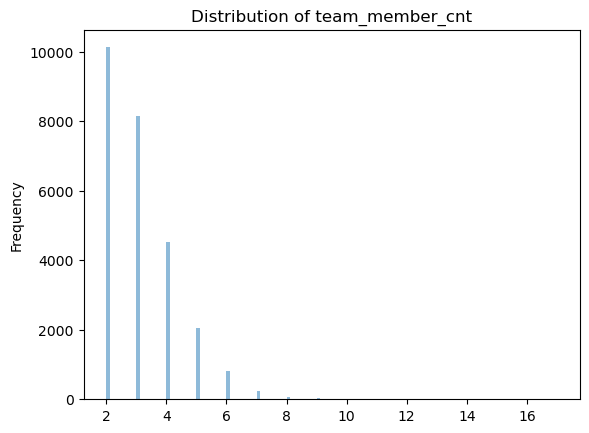

<Figure size 640x480 with 0 Axes>

In [65]:
eda(paper_orig_, ["team_member_cnt"])

In [70]:
paper_orig_["team_member_cnt"].describe()

count    26051.000000
mean         3.102107
std          1.214727
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         17.000000
Name: team_member_cnt, dtype: float64

In [72]:
print(paper_orig_.shape[0])
print(paper_orig_[paper_orig_["team_member_cnt"]<=8].shape[0])
print(paper_orig_[paper_orig_["team_member_cnt"]>8].shape[0])
print(paper_orig_[paper_orig_["team_member_cnt"]>8].shape[0]/paper_orig_.shape[0] *100)
print(paper_orig_[paper_orig_["team_member_cnt"]<=10].shape[0])
print(paper_orig_[paper_orig_["team_member_cnt"]>10].shape[0])
print(paper_orig_[paper_orig_["team_member_cnt"]>10].shape[0]/paper_orig_.shape[0] *100)

26051
25997
54
0.20728570880196537
26037
14
0.053740739319028064


In [73]:
team = paper_orig_[["id", "team"]]
print(team.shape)
display(team.head())

(26051, 2)


,id,team
621,53e99e0bb7602d97026cd68c,"[53f42ed2dabfaedd74d496dc, 53f42fa1dabfaee4dc7..."
956,53e9a46bb7602d9702d8bf24,"[53f4593ddabfaec09f210d4d, 53f6616fdabfae8dcd3..."
1248,53e9aa95b7602d970340d56c,"[53f55899dabfae387ff8045b, 53f46832dabfaedce55..."
1342,53e9abfeb7602d97035bf400,"[53f39f3adabfae4b34aaed9f, 53f43104dabfaee1c0a..."
1344,53e9ac05b7602d97035c29f5,"[560923b145cedb3396e2f7fb, 53f64fd4dabfae6a71b..."


## Merge the 3 datasets

In [47]:
# Merge paper and expertise dataframes on 'paper_id'
df_ = pd.merge(df_expertise, paper, left_on= "id", right_on= 'id', how='left')
print(df_expertise.shape)
print(df_.shape)
display(df_.head())

(64064, 2)
(64064, 3)


,id,expertise,abstract
0,53e9a0edb7602d97029d45c4,"[Mathematics, Discrete Mathematics, Graph Theo...",We show that there is no log 1 over 3-ε M appr...
1,53e9b5cfb7602d970411c8a3,"[Machine Learning, Data Science, Statistical A...",Maximum margin discriminant analysis (MMDA) wa...
2,599c7ef9601a182cd28ddd55,"[Mathematical optimization, Linear programming...",Online multi-kernel learning is promising in t...
3,5cfa5b985ced2477cb3c5177,"[Computer Science, Data Science, Data Engineer...",The range-based skyline (r-skyline) query on r...
4,57d06412ac4436735429bbfe,"[Computer Science, Data Mining, Cloud Computin...","In this demo, we present FERARI, a prototype t..."


In [81]:
df = pd.merge(team, df_, left_on = "id", right_on='id', how='left')
df = df.rename(columns = {"abstract": "task_description"})
print(team.shape)
print(df_.shape)
print(df.shape)
print(df.isna().sum())
display(df.head())

(26051, 2)
(64064, 3)
(26051, 4)
id                  0
team                0
expertise           0
task_description    0
dtype: int64


,id,team,expertise,task_description
0,53e99e0bb7602d97026cd68c,"[53f42ed2dabfaedd74d496dc, 53f42fa1dabfaee4dc7...","[Machine Learning, Artificial Intelligence, Pa...",The paper shows how a text classifier's need f...
1,53e9a46bb7602d9702d8bf24,"[53f4593ddabfaec09f210d4d, 53f6616fdabfae8dcd3...","[Mathematics, Data Science, Machine Learning, ...",A topological approach to stratification learn...
2,53e9aa95b7602d970340d56c,"[53f55899dabfae387ff8045b, 53f46832dabfaedce55...","[Computer Science, Database Systems, Transacti...","In recent years, databases have started to be..."
3,53e9abfeb7602d97035bf400,"[53f39f3adabfae4b34aaed9f, 53f43104dabfaee1c0a...","[Computer Science, Database Management, Data W...",Data warehouses are used to collect and analy...
4,53e9ac05b7602d97035c29f5,"[560923b145cedb3396e2f7fb, 53f64fd4dabfae6a71b...","[Computer Science, Discrete Mathematics, Graph...",We are given a transition system implicitly th...


In [78]:
# df = pd.merge(df_, df_author, left_on = "id", right_on='paper_id', how='left')
# print(df.shape)
# print(df.isna().sum())
# df = df.drop(columns = ["paper_id"])
# display(df.head())

# df = df[~df["id"].isin(list_paper_contain_author_lessthan5paper)]
# print(df.shape)

## Combine the expertice and abstract column

In [82]:
df['input'] = df.apply(lambda row: f"Queries: {', '.join(row['expertise'])}.\nContext: {row['task_description']}", axis=1)


In [83]:
df.head()

,id,team,expertise,task_description,input
0,53e99e0bb7602d97026cd68c,"[53f42ed2dabfaedd74d496dc, 53f42fa1dabfaee4dc7...","[Machine Learning, Artificial Intelligence, Pa...",The paper shows how a text classifier's need f...,"Queries: Machine Learning, Artificial Intellig..."
1,53e9a46bb7602d9702d8bf24,"[53f4593ddabfaec09f210d4d, 53f6616fdabfae8dcd3...","[Mathematics, Data Science, Machine Learning, ...",A topological approach to stratification learn...,"Queries: Mathematics, Data Science, Machine Le..."
2,53e9aa95b7602d970340d56c,"[53f55899dabfae387ff8045b, 53f46832dabfaedce55...","[Computer Science, Database Systems, Transacti...","In recent years, databases have started to be...","Queries: Computer Science, Database Systems, T..."
3,53e9abfeb7602d97035bf400,"[53f39f3adabfae4b34aaed9f, 53f43104dabfaee1c0a...","[Computer Science, Database Management, Data W...",Data warehouses are used to collect and analy...,"Queries: Computer Science, Database Management..."
4,53e9ac05b7602d97035c29f5,"[560923b145cedb3396e2f7fb, 53f64fd4dabfae6a71b...","[Computer Science, Discrete Mathematics, Graph...",We are given a transition system implicitly th...,"Queries: Computer Science, Discrete Mathematic..."


In [84]:
print(df["input"].iloc[0])

Queries: Machine Learning, Artificial Intelligence, Pattern Recognition, Text Classification, Active Learning, Unsupervised Learning, Expectation-Maximization Algorithm, Query-by-Committee Method, Data Labeling Techniques, Experimental Design in Machine Learning.
Context: The paper shows how a text classifier's need for labeled
                   training documents can be reduced by taking advantage of a
                   large pool of unlabeled documents. We modify the
                   Query-by-Committee (QBC) method of active learning to use
                   the unlabeled pool for explicitly estimating document
                   density when selecting examples for labeling. Then active
                   learning is combined with Expectation-Maximization in
                   order to ``fill in'' the class labels of those documents
                   that remain unlabeled. Experimental results show that the
                   improvements to active learning require less than
  

In [85]:
print(df["input"].iloc[2])

Queries: Computer Science, Database Systems, Transaction Management, Parallel Computing, Concurrency Control, Distributed Systems, Theoretical Computer Science, Composite Systems, Correctness in Computing, Nearest Neighbor Search.
Context:  In recent years, databases have started to be used as intelligentrepositories for a variety of semantically-richer systems.A consequence of such architectures is that transactionscheduling takes place throughout composite systemsconsisting of layered subsystems. Such transaction architectureshave been studied extensively. Existing theory, however,limits the degree of parallelism, and makes a number ofsimplifying assumptions which cannot be taken for grantedin practice.This paper... 


In [86]:
print(df["input"].iloc[90])

Queries: Computer Science, Database Systems, Query Optimization, Data Mining, Statistical Analysis, Wavelet Theory, Histogram Techniques, Multiresolution Analysis, OLAP (Online Analytical Processing), Algorithm Design.
Context: Query optimization is an integral part of relational database management systems. One important task in query optimization is selectivity estimation, that is, given a query P, we need to estimate the fraction of records in the database that satisfy P. Many commercial database systems maintain histograms to approximate the frequency distribution of values in the attributes of relations.In this paper, we present a technique based upon a multiresolution wavelet decomposition for building histograms on the underlying data distributions, with applications to databases, statistics, and simulation. Histograms built on the cumulative data distributions give very good approximations with limited space usage. We give fast algorithms for constructing histograms and using t

In [87]:
df.to_csv("./output/cs_paper_with_author_published_2plus.csv", index = False)

# Train Test Split

In [5]:
df = pd.read_csv("./output/cs_paper_with_author_published_2plus.csv")
print(df.shape)
display(df.head())

(26051, 5)


,id,team,expertise,task_description,input
0,53e99e0bb7602d97026cd68c,"['53f42ed2dabfaedd74d496dc', '53f42fa1dabfaee4...","['Machine Learning', 'Artificial Intelligence'...",The paper shows how a text classifier's need f...,"Queries: Machine Learning, Artificial Intellig..."
1,53e9a46bb7602d9702d8bf24,"['53f4593ddabfaec09f210d4d', '53f6616fdabfae8d...","['Mathematics', 'Data Science', 'Machine Learn...",A topological approach to stratification learn...,"Queries: Mathematics, Data Science, Machine Le..."
2,53e9aa95b7602d970340d56c,"['53f55899dabfae387ff8045b', '53f46832dabfaedc...","['Computer Science', 'Database Systems', 'Tran...","In recent years, databases have started to be...","Queries: Computer Science, Database Systems, T..."
3,53e9abfeb7602d97035bf400,"['53f39f3adabfae4b34aaed9f', '53f43104dabfaee1...","['Computer Science', 'Database Management', 'D...",Data warehouses are used to collect and analy...,"Queries: Computer Science, Database Management..."
4,53e9ac05b7602d97035c29f5,"['560923b145cedb3396e2f7fb', '53f64fd4dabfae6a...","['Computer Science', 'Discrete Mathematics', '...",We are given a transition system implicitly th...,"Queries: Computer Science, Discrete Mathematic..."


In [6]:
# Create a new DataFrame excluding redundant clumns
df_to_convert = df[["id", 'input', 'team']]
print(df_to_convert.shape)
df_to_convert.head()

(26051, 3)


,id,input,team
0,53e99e0bb7602d97026cd68c,"Queries: Machine Learning, Artificial Intellig...","['53f42ed2dabfaedd74d496dc', '53f42fa1dabfaee4..."
1,53e9a46bb7602d9702d8bf24,"Queries: Mathematics, Data Science, Machine Le...","['53f4593ddabfaec09f210d4d', '53f6616fdabfae8d..."
2,53e9aa95b7602d970340d56c,"Queries: Computer Science, Database Systems, T...","['53f55899dabfae387ff8045b', '53f46832dabfaedc..."
3,53e9abfeb7602d97035bf400,"Queries: Computer Science, Database Management...","['53f39f3adabfae4b34aaed9f', '53f43104dabfaee1..."
4,53e9ac05b7602d97035c29f5,"Queries: Computer Science, Discrete Mathematic...","['560923b145cedb3396e2f7fb', '53f64fd4dabfae6a..."


In [7]:
list_paper_id = df["id"].unique()

# Step 2: Split 'id' into train and test while ensuring all test 'id' are in train set
train_set, test_set = train_test_split(df_to_convert, test_size=0.3, random_state= 617)
print(train_set.shape)
print(test_set.shape)

(18235, 3)
(7816, 3)


In [8]:
# get a list of unique author id in Train set

train_set_ = train_set[["id", "team"]]
print(train_set_.shape)
display(train_set_.head())

# Step 1: Flatten the lists in the 'author_id' column
train_set_["team"] = train_set_["team"].apply(string_to_python)
train_set_explode = train_set_.explode("team", ignore_index = True)
print(train_set_explode.shape)
display(train_set_explode.head())
# Step 2: Get the unique author_ids
list_train_author_id = train_set_explode["team"].unique()
print(len(list_train_author_id))


(18235, 2)


,id,team
1735,53e99afdb7602d970238b1fa,"['53f4b25bdabfaee4dc8b4e8d', '53f590a2dabfaedd..."
10729,53e9af8db7602d97039d6262,"['53f451acdabfaec09f1f4b75', '53f431c3dabfaedc..."
17752,5550489045ce0a409eb6f79b,"['542aa53edabfae61d4999e7d', '542ce9bddabfae21..."
10799,53e9afb3b7602d97039ff004,"['53f44f3cdabfaedd74e11a95', '53f4a909dabfaeb2..."
11072,53e9b049b7602d9703aad045,"['54860978dabfae9b40133b60', '53f4333edabfaeec..."


(56672, 2)


/tmp/ipykernel_2129336/1416945734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_["team"] = train_set_["team"].apply(string_to_python)


,id,team
0,53e99afdb7602d970238b1fa,53f4b25bdabfaee4dc8b4e8d
1,53e99afdb7602d970238b1fa,53f590a2dabfaedd59f8045b
2,53e99afdb7602d970238b1fa,53f79af8dabfae90ec10b2ab
3,53e9af8db7602d97039d6262,53f451acdabfaec09f1f4b75
4,53e9af8db7602d97039d6262,53f431c3dabfaedce54fd486


18941


In [10]:
# get a list of unique author id in Test set

test_set_ = test_set[["id", "team"]]
print(test_set_.shape)
display(test_set_.head())

# Step 1: Flatten the lists in the 'author_id' column
test_set_["team"] = test_set_["team"].apply(string_to_python)
test_set_explode = test_set_[["id", "team"]].explode("team", ignore_index = True)
print(test_set_explode.shape)
display(test_set_explode.head())

# Step 2: Get the unique author_ids
list_test_author_id = test_set_explode["team"].unique()
print(len(list_test_author_id))


(7816, 2)


,id,team
3137,53e99e38b7602d97026fd87e,"['53f43762dabfaee4dc78b72d', '540ff90edabfae45..."
24995,5f8d6be69fced0a24bbaaf49,"['542b5c16dabfae20065fbfa8', '54059314dabfae8f..."
25786,6215a4242c356815940384bd,"['54055925dabfae44f0804adf', '561557eb45ce1e59..."
5554,53e9a3e1b7602d9702cf7a50,"['53f43674dabfaee1c0a9df6e', '54401f44dabfae80..."
21149,599c7b59601a182cd272c177,"['562cd33245cedb3398cd64ca', '53f42d96dabfaee0..."


(24141, 2)


/tmp/ipykernel_2129336/3920315506.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_["team"] = test_set_["team"].apply(string_to_python)


,id,team
0,53e99e38b7602d97026fd87e,53f43762dabfaee4dc78b72d
1,53e99e38b7602d97026fd87e,540ff90edabfae450f4bd6e6
2,53e99e38b7602d97026fd87e,53f480a2dabfae963d25b1b5
3,53e99e38b7602d97026fd87e,53f4804ddabfae963d259647
4,5f8d6be69fced0a24bbaaf49,542b5c16dabfae20065fbfa8


11944


In [11]:
list_authorid_should_not_be_in_test = []
for authorid in list_test_author_id:
    if authorid not in list_train_author_id:
        list_authorid_should_not_be_in_test.append(authorid)
print(len(list_authorid_should_not_be_in_test))


2970


In [12]:
test_set_explode_keep = test_set_explode[~test_set_explode["team"].isin(list_authorid_should_not_be_in_test)]


In [13]:
test_set_explode_move = test_set_explode[test_set_explode["team"].isin(list_authorid_should_not_be_in_test)]

In [14]:
print(test_set_explode_keep.shape)
print(test_set_explode_move.shape)

(20418, 2)
(3723, 2)


In [15]:
list_paperid_to_keep_in_testset = test_set_explode_keep["id"].unique()
print(len(list_paperid_to_keep_in_testset))
print(len(list_paperid_to_keep_in_testset) / df.shape[0])

7495
0.2877048865686538


In [23]:
list_paperid_to_move_in_testset = test_set_explode_move["id"].unique()
print(len(list_paperid_to_move_in_testset))
print((test_set_.shape[0] - len(list_paperid_to_move_in_testset) )/ df.shape[0])

2564
0.2016045449310967


In [24]:
appeared_twice = [id for id in list_paperid_to_move_in_testset if id in list_paperid_to_keep_in_testset]

In [25]:
appeared_twice2 = [id for id in list_paperid_to_keep_in_testset if id in list_paperid_to_move_in_testset]

In [26]:
print(len(appeared_twice))
print(len(appeared_twice2))

2243
2243


In [27]:
assert set(appeared_twice) == set(appeared_twice2)

In [29]:
final_test_set = test_set[~test_set["id"].isin(list_paperid_to_move_in_testset)]
# shuffle the rows
final_test_set = final_test_set.sample(frac=1, random_state=42).reset_index(drop=True)
print(final_test_set.shape)
display(final_test_set.head())

(5252, 3)


,id,input,team
0,53e9aea4b7602d97038c8784,"Queries: Computer Science, Parallel Computing,...","['53f44cfedabfaefedbb2d8fc', '53f48cf4dabfaea7..."
1,53e99a67b7602d97022d3c40,"Queries: Computer Science, Database Systems, D...","['53f5588bdabfae3863f8045b', '53f4305edabfaedc..."
2,53e9a415b7602d9702d31bab,"Queries: Information Retrieval, Knowledge Mana...","['53f435afdabfaee1c0a97b2a', '53f642a7dabfaed4..."
3,53e9b108b7602d9703b83a16,"Queries: Data Mining, Scholarly Data Analysis,...","['53f437e4dabfaee2a1cf43bb', '53f43211dabfaeb2..."
4,53e9b98ab7602d97045793df,"Queries: Computer Science, Database Systems, D...","['53f446abdabfaeb22f4c0ae8', '53f4666cdabfaec0..."


In [30]:
test_set_move = test_set[test_set["id"].isin(list_paperid_to_move_outof_testset)]
print(test_set_move.shape)

(2564, 3)


In [31]:
final_train_set = pd.concat([train_set, test_set_move])
# shuffle the rows
final_train_set = final_train_set.sample(frac=1, random_state=42).reset_index(drop=True)
print(final_train_set.shape)
print(train_set.shape[0] + test_set_move.shape[0])
display(final_train_set.head())

(20799, 3)
20799


,id,input,team
0,53e9af3ab7602d970397a5b5,"Queries: Data mining, Information retrieval, C...","['53f42d67dabfaedd74d36ddd', '53f48babdabfaea7..."
1,53e9ae9cb7602d97038bdd01,"Queries: Computer Science, Information Retriev...","['53f436efdabfaee2a1ceb382', '53f4ae26dabfaee0..."
2,53e9b62db7602d9704185386,"Queries: Computer Science, Database Systems, D...","['53f453b6dabfaee2a1d699bd', '53f55e9fdabfae52..."
3,53e9b22eb7602d9703cc8707,"Queries: Information Science, Web Technologies...","['53f43283dabfaee4dc75af98', '53f325efdabfae9a..."
4,555048d545ce0a409eb71cdd,"Queries: Computer Science, Data Science, Machi...","['53f42d86dabfaee43ebc6a6a', '542a3df7dabfae64..."


In [32]:
final_train_id = final_train_set["id"].tolist()
final_test_id = final_test_set["id"].tolist()

In [33]:
print([id for id in final_train_id if id in final_test_id])
print([id for id in final_test_id if id in final_train_id])

[]
[]


In [34]:
assert df.shape[0] == len(final_train_id) + len(final_test_id)

In [35]:
# Define a function to convert the DataFrame to a Dataset object
def create_dataset(df):
    return Dataset.from_pandas(df)

In [36]:
# Create Dataset objects for train and test sets
train_dataset = create_dataset(final_train_set)
test_dataset = create_dataset(final_test_set)

# Combine them into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [37]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'input', 'team'],
        num_rows: 20799
    })
    test: Dataset({
        features: ['id', 'input', 'team'],
        num_rows: 5252
    })
})

In [175]:
dataset_dict.save_to_disk('data/cs_paper_author_over2pub/dataset_directory')

Saving the dataset (0/1 shards):   0%|          | 0/20799 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7495 [00:00<?, ? examples/s]